In [1]:
%load_ext autoreload

In [2]:
#imports
%autoreload 2
import pandas as pd
import flow, os
from flow import Model, PTLoss, EFN
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from torch_geometric.data import Data, DataLoader
from torch_geometric.utils import dense_to_sparse
import torch
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.cm import RdBu
plt.style.use("dark_paper")

In [3]:
def readme(path, string):
    with open(os.path.join(path,'readme.txt'), 'w') as f:
        f.write(string)

In [25]:
def process(df,target,scalars):
    vec4 = df[df['STATUS']>0][["E","px","py","pz"]].iloc[1:].values
    x = vec4[:,1:]/vec4[:,0].reshape(-1,1)
    x = torch.from_numpy(x).float()
    y = torch.from_numpy(target).float().view(1,4)
#     distances = getDR(x)
#     edge_index=torch_geometric.nn.radius_graph(distances,r=1)#GCNConv adds self loops
#     edge_index=dense_to_sparse(torch.ones(x.shape[0],x.shape[0]).fill_diagonal_(0))[0]#complete
    edge_index=dense_to_sparse(torch.eye(x.shape[0]))[0]#self only
#     edge_index=dense_to_sparse(torch.ones(x.shape[0],x.shape[0]))[0]#complete graph
#    edge_index=None
    data = Data(x=x, y=y, edge_index=edge_index) 
    data.p = torch.from_numpy(vec4).float()
    data.scalars = torch.Tensor(scalars).float().view(1,4)
    return data

# Load Data

In [26]:
events_breit = pd.read_hdf('data/EIC/breit0.h5', key=f'data')
targets = pd.read_hdf("data/EIC/targets_breit0.h5",key='data').values
scalars = pd.read_hdf("data/EIC/scalars0.h5",key='data').values

In [27]:
train_set = [process(events_breit[events_breit['EVENT']==i],y,z) for i,y,z in zip(range(1000),targets,scalars)]
train_loader = DataLoader(train_set, batch_size=10,shuffle=True, num_workers=12)

In [28]:
val_set = [process(events_breit[events_breit['EVENT']==i],y,z) for i,y,z in zip(range(10000,12000),targets[10000:12000],scalars[10000:12000])]
val_loader = DataLoader(val_set, batch_size=1,shuffle=False, num_workers=12)

In [29]:
# Gather some statistics about the first graph.
data = train_set[1]  # Get the first graph object.
print(data)
print('=============================================================')
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.contains_isolated_nodes()}')
print(f'Contains self-loops: {data.contains_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Data(edge_index=[2, 8], p=[8, 4], scalars=[1, 4], x=[8, 3], y=[1, 4])
Number of nodes: 8
Number of edges: 8
Average node degree: 1.00
Contains isolated nodes: True
Contains self-loops: True
Is undirected: True


# Instantiate network 

In [30]:
torch.manual_seed(0)
hidden_channels = 128
nn = torch.nn.Sequential(torch.nn.Linear(3+4,hidden_channels),
                         torch.nn.ReLU(),
                         torch.nn.BatchNorm1d(hidden_channels),
                         torch.nn.Linear(hidden_channels,hidden_channels),
                         torch.nn.ReLU(),
                         torch.nn.Linear(hidden_channels,hidden_channels),
                         torch.nn.ReLU(),                                       
                         torch.nn.Linear(hidden_channels,hidden_channels),
                         torch.nn.ReLU(),
                         torch.nn.Dropout(0.5),
                         torch.nn.Linear(hidden_channels,1),
                         torch.nn.Sigmoid())
efn = EFN(nn)
#efn_script = torch.jit.script(efn)
optim  = torch.optim.Adam(efn.parameters(),weight_decay=0,lr=1e-5)
module = Model(efn, optim=optim,
               criterion=PTLoss(torch.nn.MSELoss()))
#module.to("cuda:0")

In [32]:
train_set = [process(events_breit[events_breit['EVENT']==i],y,z) for i,y,z in zip(range(10000),targets,scalars)]
train_loader = DataLoader(train_set, batch_size=10,shuffle=True, num_workers=12)

In [ ]:
# Run
logdir = "./lightning_logs/test_run/"
pl.seed_everything(42)
bar = flow.utils.ProgressBar()
name = "no_weight_decay1"
log = flow.utils.Logger(logdir, name=name,default_hp_metric=False)
checkpoint_path = os.path.join(logdir,f"{name}/version_{log.version}")
checkpoint_callback = ModelCheckpoint(dirpath=checkpoint_path,filename="weights.cpkt",save_top_k=1,monitor='val_loss',mode='min')
trainer = pl.Trainer(logger=log, gpus=1, max_epochs=200, progress_bar_refresh_rate=1,callbacks=[bar,checkpoint_callback])
trainer.fit(module,train_dataloader=train_loader,val_dataloaders=val_loader)
readme(checkpoint_path, "small dataset 1k")

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | EFN  | 50.9 K


Epoch 165:  78%|#######7  | 2325/3000 [00:20<00:06, 111.09it/s, loss=0.509, v_num=28, val_loss=0.45] 

In [133]:
efn.to("cuda:0")
weights = list()
theta = list()
phi = list()
pt = list()
E = list()
for i in range(len(train_set)):
    batch = train_set[i]
    batch.to("cuda:0")
    with torch.no_grad():
        weights.append(efn(batch).cpu().numpy())
    theta.append(events_breit[i].loc[4:,['theta']].values)
    phi.append(events_breit[i].loc[4:,['phi']].values)
    pt.append(np.abs(events_breit[i].loc[4:,['pT']].values).sum())
    E.append(np.abs(events_breit[i].loc[4:,['E']].values))
theta = np.array(theta)
phi = np.array(phi)
E = np.array(E)
weights = np.array(weights)
pt = np.array(pt)

/home/kitouni/anaconda3/envs/gnn/lib/python3.7/site-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  app.launch_new_instance()
/home/kitouni/anaconda3/envs/gnn/lib/python3.7/site-packages/ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/kitouni/anaconda3/envs/gnn/lib/python3.7/site-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated.

In [157]:
np.argwhere(pt>15)

array([[ 28],
       [ 99],
       [236],
       [578],
       [755]])

In [180]:
events_breit[99].loc[3:,['E']].sum()

E    200.864764
dtype: float64

In [182]:
events_breit[99].loc[:1,['E']].sum()

E    200.864733
dtype: float64

In [176]:
events_breit[99]

,NAME,ID,STATUS,E,px,py,pz,mass,pT,eta,phi,theta
0,p+,2212,-12,195.601087,2.930989e-14,3.108624e-14,-195.598837,0.938270,4.272498e-14,-36.753206,0.814801,3.141593
1,e-,11,-12,5.263646,-1.112992e+00,-1.361959e+00,4.961078,0.000511,1.758887e+00,1.760128,-2.255937,0.340711
2,cbar,-4,-23,5.075560,-2.386062e-04,-2.919803e-04,4.848846,1.500000,3.770749e-04,10.154955,-2.255937,0.000078
3,e-,11,44,5.263646,-1.112992e+00,-1.361959e+00,-4.961078,0.000511,1.758887e+00,-1.760128,-2.255937,2.800881
4,pi+,211,83,6.134615,6.622634e-01,-6.270971e-01,-6.064831,0.139570,9.120546e-01,-2.593316,-0.758131,2.992327
5,K-,-321,83,0.834078,-2.534906e-01,-3.881668e-01,-0.486862,0.493680,4.636064e-01,-0.916403,-2.149309,2.380657
6,K_L0,130,91,4.503628,-3.918242e-01,2.506037e+00,-3.687994,0.497610,2.536484e+00,-1.168961,1.725893,2.539123
7,pi-,-211,91,2.581181,-2.020380e-01,8.278216e-01,-2.432469,0.139570,8.521197e-01,-1.771439,1.810176,2.804641
8,p+,2212,91,13.402095,-4.250913e-01,4.694652e-01,-13.354202,0.938270,6.333247e-01,-3.742312,2.306631,3.094203
9,pi+,211,91,9.641180,-1.251541e-01,-1.364539e-01,-9.638392,0.139570,1.851573e-01,-4.645543,-2.313028,3.122385


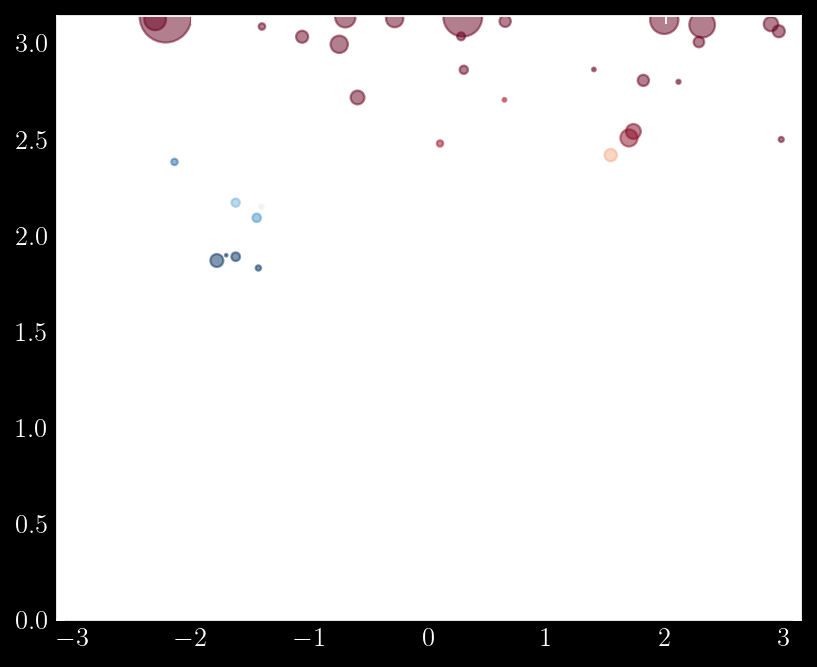

In [183]:
fig,ax = plt.subplots(1,1,figsize=(6,5), dpi=160)
minpt = 20
maxpt = 21
cond = (pt>minpt)&(pt<maxpt)
cond = 99
weights_ = np.concatenate(weights[cond]).flatten()
theta_ = np.concatenate(theta[cond]).flatten()
phi_ = np.concatenate(phi[cond]).flatten()
E_ = np.concatenate(E[cond]).flatten()
colors = RdBu(weights_/weights_.max())
plt.scatter(phi_,theta_, alpha = 0.5, s=E_*10, c=colors)
plt.xlim([-np.pi,np.pi])
plt.ylim([0,np.pi])
ax.set_facecolor('w')

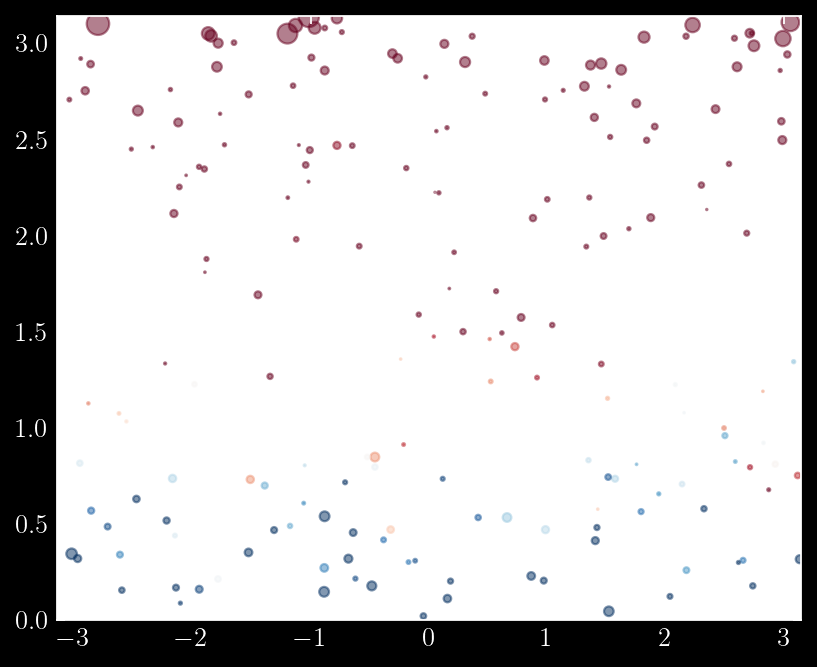

In [148]:
fig,ax = plt.subplots(1,1,figsize=(6,5), dpi=160)
minpt = 0
maxpt = 2
weights_ = np.concatenate(weights[(pt>minpt)&(pt<maxpt)]).flatten()
theta_ = np.concatenate(theta[(pt>minpt)&(pt<maxpt)]).flatten()
phi_ = np.concatenate(phi[(pt>minpt)&(pt<maxpt)]).flatten()
E_ = np.concatenate(E[(pt>minpt)&(pt<maxpt)]).flatten()
colors = RdBu(weights_/weights_.max())
plt.scatter(phi_,theta_, alpha = 0.5, s=E_*10, c=colors)
plt.xlim([-np.pi,np.pi])
plt.ylim([0,np.pi])
ax.set_facecolor('w')

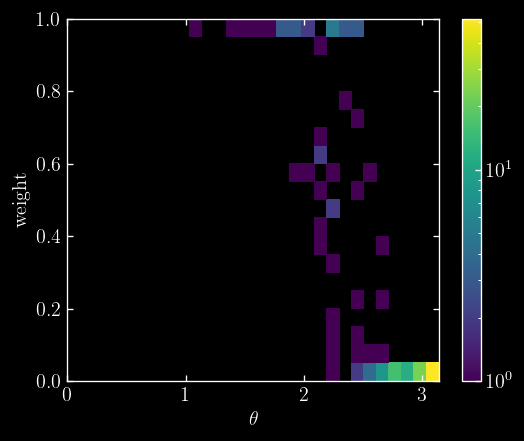

In [112]:
from matplotlib.colors import LogNorm
fig,ax = plt.subplots(1,1,figsize=(5,4), dpi=120)
minpt = 15
theta_ = np.concatenate(theta[pt>minpt]).flatten()
weights_ = np.concatenate(weights[pt>minpt]).flatten()
plt.hist2d(theta_,weights_,bins=20,norm=LogNorm())
plt.xlabel(r"$\theta$")
plt.ylabel("weight")
plt.xlim([0,np.pi])
plt.colorbar()
plt.show()

(array([23.,  2.,  0.,  1.,  0.,  0.,  2.,  1.,  1.,  4.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <BarContainer object of 10 artists>)

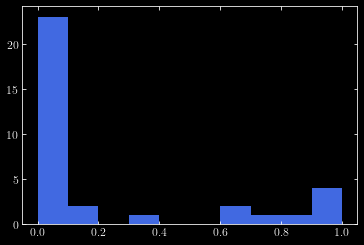

In [100]:
plt.hist(np.concatenate(weights[pt>23]).flatten())

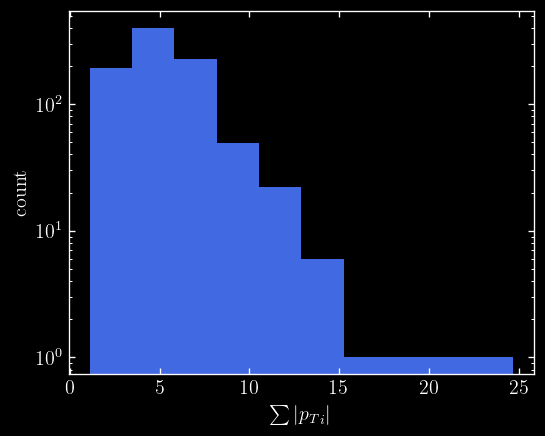

In [81]:
fig,ax = plt.subplots(1,1,figsize=(5,4), dpi=120)
out = plt.hist(pt)
plt.yscale('log')
plt.xlabel(r"$\sum|{p_T}_i|$")
plt.ylabel("count")
plt.show()

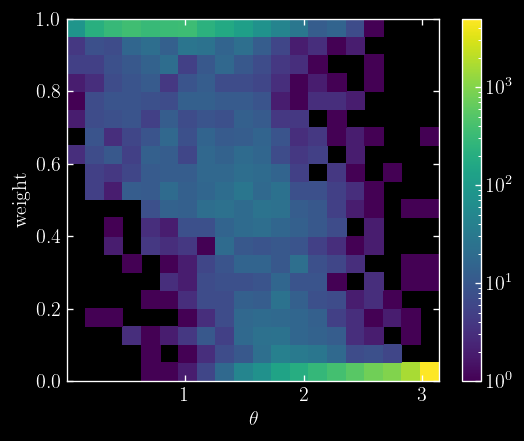

In [76]:
from matplotlib.colors import LogNorm
fig,ax = plt.subplots(1,1,figsize=(5,4), dpi=120)
plt.hist2d(theta,weights,bins=20,norm=LogNorm())
plt.xlabel(r"$\theta$")
plt.ylabel("weight")
plt.colorbar()
plt.show()

IndexError: boolean index did not match indexed array along dimension 0; dimension is 15098 but corresponding boolean dimension is 900

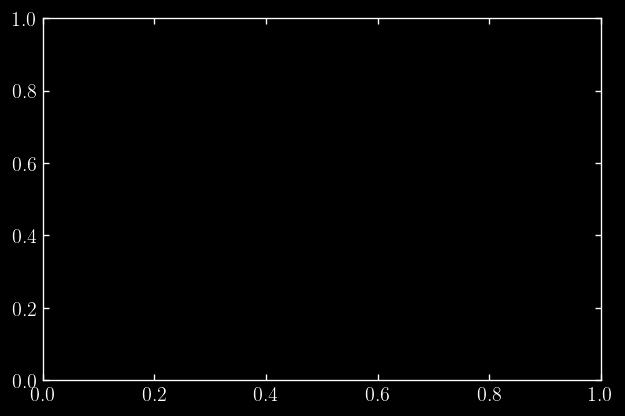

In [83]:
fig,ax = plt.subplots(1,1,figsize=(6,4), dpi=120)
plt.hist(weights[pt>10])
plt.xlabel("weight")
plt.ylabel("count")
plt.show()

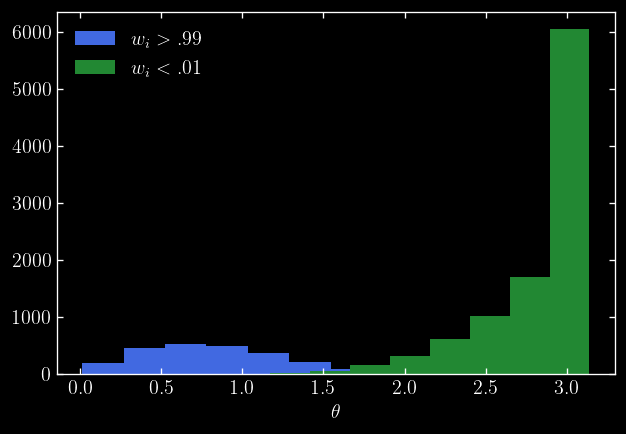

In [72]:
fig,ax = plt.subplots(1,1,figsize=(6,4), dpi=120)
plt.hist(theta[weights>.99],label=r'$w_i>.99$')
plt.hist(theta[weights<.01],label=r'$w_i<.01$')
plt.xlabel(r"$\theta$")
plt.ylabel("count")
plt.legend()